# Prerequisite structure discovery in intelligent tutoring systems

This repository provides implementations for the paper "prerequisite structure discovery in intelligent tutoring systems".

This notebook presents an example of training and evaluation of the proposed PKT model.

## 1. Synthetic data generation

Data is synthesized using a custom student model implementation, modeling learner variations in skills and learning speed, prerequisite relations between skills, guess and slip probabilities, and learner forgetting.

In [1]:
import torch
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import random

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from student_models.student_model import StudentModel

In [2]:
n_st = 400  # Number of student trajectories to simulate
n_ex = 30  # Number of exercises
n_kc = 10  # Number of knowledge components
T = 300  # Length of the learners' trajectories

In [3]:
# Instantiate the student model
sm = StudentModel(n_ex, n_kc, n_st)
sm.reset_student_trajectories()

# For storing the trajectories
data_exs = torch.zeros(T, n_st)
data_suc = torch.zeros(T, n_st)
data_st_kcs = torch.zeros(T, n_st, n_kc)
data_lt_kcs = torch.zeros(T, n_st, n_kc)

# For each learner, we choose one KC never to be recommended
st_removed_kc = np.random.choice(np.arange(n_kc), size=n_st)

for t in tqdm(range(T)):

    # Exercises recommended at time t
    exs = torch.zeros(n_st).long()
    for st in range(n_st):
        ex_probas = torch.ones(n_ex) - sm.ex_graph[:, st_removed_kc[st]]
        ex_probas = ex_probas / torch.sum(ex_probas)
        ex = np.random.choice(np.arange(n_ex), p=ex_probas.numpy())
        exs[st] = ex

    data_exs[t] = exs

    # Simulate exercise with the student model, with guess proba of 0.2, and splip proba of 0.1
    proba, success = sm.simulate_exercise(exs)
    success = torch.rand_like(proba) < (0.2 + proba * 0.7)
    
    # Store the result and current KC levels (long-term and short-term)
    data_suc[t] = success
    data_st_kcs[t] = sm.st_kc_elo.clone()
    data_lt_kcs[t] = sm.lt_kc_elo.clone()
    
pk.dump(
    (sm.kc_graph, sm.ex_graph, data_exs, data_suc, sm), 
    open('data/synthetic_data.pk', 'wb')
)

  0%|          | 0/300 [00:00<?, ?it/s]

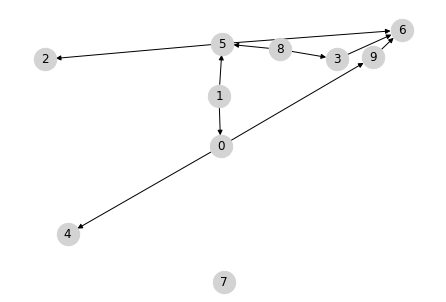

In [4]:
# Prerequisite relations between KCs sampled with our student model
sm.plot_kc_graph()

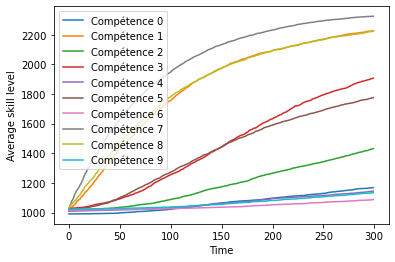

In [5]:
# Average evolution of the level on each skill, we can see that skills that have no parent 
# in the prerequisite graph can be acquired faster

plt.figure(figsize=(6, 4))
for k in range(n_kc):
    plt.plot(torch.mean(data_lt_kcs[:, :, k], axis=1), label="Compétence " + str(k))
plt.xlabel("Time")
plt.ylabel("Average skill level")
plt.legend()
plt.show()

## 2. Training the model on the observed data

In [6]:
from student_models.pkt import PKT
from student_models.dkt import DKT
from student_models.skt import SKT
from sklearn.metrics import roc_auc_score

### 2.1. Proposed PKT model

In [7]:
iterations = 50  # Number of training iterations
batch_size = 1000

split_id = 300  # Number of learner trajectories to use for training

train_losses = torch.zeros(iterations)
train_aucs = torch.zeros(iterations)

# Data KC-exercise graph
data_ex_graph = pk.load(open('data/synthetic_data.pk', 'rb'))[1]

# Initial estimate of the KC graph
kc_gamma = torch.randn(n_kc, n_kc)

# Model instantiation
pkt = PKT(n_kc, n_ex, data_ex_graph, kc_gamma, n_st=n_st, lr=0.02)

# Prepare data
(
    st_train_perm, ex_train_perm, su_train_perm, fa_train_perm, y_train_perm,
    st_test, ex_test, su_test, fa_test, y_test
) = PKT.prepare_data('data/synthetic_data.pk')

In [8]:
for i in tqdm(range(iterations)):

    mini_batches = (split_id * T) // batch_size 
    total_loss = 0
    total_auc = 0

    for b in range(mini_batches):
        
        # Batched training_data
        batch_st = st_train_perm[b*batch_size:(b+1)*batch_size] 
        batch_ex = ex_train_perm[b*batch_size:(b+1)*batch_size]
        batch_su = su_train_perm[b*batch_size:(b+1)*batch_size] 
        batch_fa = fa_train_perm[b*batch_size:(b+1)*batch_size]
        batch_y = y_train_perm[b*batch_size:(b+1)*batch_size]

        # Training
        pkt.opt.zero_grad()
        pred, _ = pkt.predict(batch_st, batch_ex, batch_su, batch_fa)
        loss = torch.nn.BCELoss()(pred, batch_y)
        
        # Regularization
        loss = loss + 1e-3 * torch.mean(torch.abs(torch.sigmoid(pkt.kc_gamma)))
        loss = loss + 1e-6 * torch.mean((pkt.ex_elo - 1500.) ** 2)
        loss = loss + 1e-2 * torch.mean((pkt.pkt_cell.log_fa_speed[:split_id]  - pkt.log_fa_speed_mean)**2)
        loss = loss + 1e-2 * torch.mean((pkt.pkt_cell.log_su_speed[:split_id]  - pkt.log_su_speed_mean)**2)
        loss = loss + 1e-6 * torch.mean((pkt.pkt_cell.initial_kc_elo - pkt.pkt_cell.base_elo.unsqueeze(-1).repeat(1, n_kc))[:split_id]**2)
        loss.backward()
        pkt.opt.step()

        total_loss += loss.clone().detach().item()
        total_auc += roc_auc_score(batch_y, pred.detach())

    total_loss /= mini_batches
    total_auc /= mini_batches
    train_losses[i] = total_loss
    train_aucs[i] = total_auc

  0%|          | 0/50 [00:00<?, ?it/s]

### 2.2. DKT

In [9]:
iterations = 100  # Number of training iterations
batch_size = 20

split_id = 300  # Number of learner trajectories to use for training

patience = 20

train_losses = torch.zeros(iterations)
train_aucs = torch.zeros(iterations)
test_losses = torch.zeros(iterations)
test_aucs = torch.zeros(iterations)

# Data KC-exercise graph
data_ex_graph = pk.load(open('data/synthetic_data.pk', 'rb'))[1]

# Initial estimate of the KC graph
kc_gamma = torch.randn(n_kc, n_kc)

# Model instantiation
dkt = DKT(n_kc, n_ex, data_ex_graph, d_h=64, lr=0.01)

# Prepare data
train_x, train_ex, train_y, test_x, test_ex, test_y = DKT.prepare_data('data/synthetic_data.pk')

In [ ]:
best_index = 0
best_auc = 0.

for i in tqdm(range(iterations)):

    mini_batches = (split_id) // batch_size 
    total_loss = 0
    total_auc = 0

    for b in range(mini_batches):

        dkt.init_students(batch_size)
        
        batch_x = train_x[b*batch_size:(b+1)*batch_size] 
        batch_ex = train_ex[b*batch_size:(b+1)*batch_size] 
        batch_y = train_y[b*batch_size:(b+1)*batch_size]

        dkt.opt.zero_grad()
        dkt.reset_students()
        pred_y, _ = dkt(batch_x, batch_ex)
        loss = torch.nn.BCELoss()(pred_y, batch_y)

        loss.backward()
        dkt.opt.step()

        total_loss += loss.detach()
        total_auc += roc_auc_score(batch_y.reshape(-1), pred_y.detach().reshape(-1))

    total_loss /= mini_batches
    total_auc /= mini_batches
    train_losses[i] = total_loss
    train_aucs[i] = total_auc

    with torch.no_grad():
        dkt.init_students(n_st-split_id)
        dkt.reset_students()
        pred_y, _ = dkt(test_x, test_ex)
        loss = torch.nn.BCELoss()(pred_y, test_y)
        test_losses[i] = loss.detach()
        test_aucs[i] = roc_auc_score(test_y.reshape(-1), pred_y.detach().reshape(-1))

    # Early stopping
    if test_aucs[i] > best_auc:
        best_auc = test_aucs[i]
        best_index = i
        pk.dump(dkt, open('results/best_dkt_temp.pk', 'wb'))
    elif (i-best_index) > patience:
        break

best_dkt = pk.load(open('results/best_dkt_temp.pk', 'rb')) 

  0%|          | 0/100 [00:00<?, ?it/s]

### 2.3. SKT

In [ ]:
iterations = 200  # Number of training iterations
batch_size = 50

split_id = 300  # Number of learner trajectories to use for training

patience = 50

train_losses = torch.zeros(iterations)
train_aucs = torch.zeros(iterations)
test_losses = torch.zeros(iterations)
test_aucs = torch.zeros(iterations)

# Data KC-exercise graph
data_ex_graph = pk.load(open('data/synthetic_data.pk', 'rb'))[1]

# Initial estimate of the KC graph
kc_gamma = torch.randn(n_kc, n_kc)

# Model instantiation
skt = SKT(n_ex, n_kc, data_ex_graph, d_e=16, d_c=16, d_h=16)
skt.kc_gamma = torch.nn.Parameter(kc_gamma)

# Prepare data
train_x, train_y, test_x, test_y = SKT.prepare_data('data/synthetic_data.pk')

In [ ]:
opt = torch.optim.Adam(skt.parameters(), lr=0.01)

best_index = 0
best_auc = 0.

for i in tqdm(range(iterations)):

    mini_batches = (split_id) // batch_size 
    total_loss = 0
    total_auc = 0

    for b in range(mini_batches):

        batch_x = train_x[b*batch_size:(b+1)*batch_size] 
        batch_y = train_y[b*batch_size:(b+1)*batch_size]
        pred_y = torch.zeros_like(batch_y)

        opt.zero_grad()

        skt.init_students(batch_size)
        skt.reset_students()

        for t in range(T):
            pred_y[:, t], _ = skt.predict(skt.h, batch_x[:, t])
            skt.h = skt.skt_cell(skt.h, batch_x[:, t], batch_y[:, t])
            
        if torch.sum(torch.isnan(pred_y).float())>0:
            i = iterations-1
            break

        loss = torch.nn.BCELoss()(pred_y, batch_y)
        loss = loss + 1e-2 * torch.mean(torch.abs(torch.sigmoid(skt.kc_gamma)))
        loss.backward()
        opt.step()

        total_loss += loss.detach()
        total_auc += roc_auc_score(batch_y.reshape(-1), pred_y.detach().reshape(-1))

    total_loss /= mini_batches
    total_auc /= mini_batches
    train_losses[i] = total_loss
    train_aucs[i] = total_auc

    with torch.no_grad():

        skt.init_students(test_x.shape[0])
        skt.reset_students()
        pred_y = torch.zeros_like(test_y)

        for t in range(T):
            pred_y[:, t], _ = skt.predict(skt.h, test_x[:, t])
            skt.h = skt.skt_cell(skt.h, test_x[:, t], test_y[:, t])
            
        if torch.sum(torch.isnan(pred_y).float())>0:
            i = iterations-1
            break

        loss = torch.nn.BCELoss()(pred_y, test_y)
        test_losses[i] = loss.detach()
        test_aucs[i] = roc_auc_score(test_y.reshape(-1), pred_y.detach().reshape(-1))

    # Early stopping
    if test_aucs[i] > best_auc:
        best_auc = test_aucs[i]
        best_index = i
        pk.dump(skt, open('results/best_skt_temp.pk', 'wb'))
    elif (i-best_index) > patience:
        break

best_skt = pk.load(open('results/best_skt_temp.pk', 'rb'))

In [ ]:
from utils import clean_graph
pkt_graph = (clean_graph(torch.sigmoid(pkt.kc_gamma).detach())>0.1).float().T
skt_graph = (clean_graph(torch.sigmoid(best_skt.kc_gamma).detach())>0.1).float()
data_kc_graph = pk.load(open('data/synthetic_data.pk', 'rb'))[0]

In [ ]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(data_kc_graph, cmap='magma')
axes[0].set_title('Ground-truth graph')

axes[1].imshow(pkt_graph, cmap='magma')
axes[1].set_title('PKT-L')

# Plot the third matrix
axes[2].imshow(skt_graph, cmap='magma')
axes[2].set_title('SKT-L')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()

## 3. Tutoring models

Here we use the two implemented tutoring models. We show experiments with ZPDES and the graphs obtained from PKT-L and SKT-L, as well as experiments with MBT and the PKT, DKT, and SKT, trained KT models.

### 3.1. ZPDES

In [ ]:
from tutoring_models.zpdes import ZPDES

In [ ]:
def simulate_ZPDES_with_synthetic_students(student_model, kc_graph, T, n_st):
    
    student_kcs = torch.zeros(T, n_st, n_kc)

    activated_exs = torch.zeros(T, n_st, n_ex)
    activated_kcs = torch.zeros(T, n_st, n_kc)

    for st in tqdm(range(n_st)):

        zpdes = ZPDES(kc_graph, student_model.ex_graph)

        ## Simulate one student
        zpdes.reset()
        student_model.init_student_parameters()
        student_model.reset_student_trajectories()

        for t in range(T):

            # Measure ground truth level
            student_kcs[t, st] = student_model.lt_kc_elo.detach()[0]

            # Find best exercise
            exs = torch.zeros(student_model.n_st)
            exs[0] = zpdes.choose_action()

            # Simulate exercise with ground truth model
            _, success = student_model.simulate_exercise(exs.long())

            # Update ZPD
            zpdes.learn_from_exercise(exs[0].long(), success[0].float())
            activated_exs[t, st] = zpdes.activated_exs.clone()
            activated_kcs[t, st] = zpdes.activated_kcs.clone()
            
    return student_kcs, activated_exs, activated_kcs

In [ ]:
ground_truth_sm = pk.load(open('data/synthetic_data.pk', 'rb'))[-1]

T = 300
n_st = 300

gt_l_results = simulate_ZPDES_with_synthetic_students(ground_truth_sm, ground_truth_sm.kc_graph, T, n_st)
pkt_l_results = simulate_ZPDES_with_synthetic_students(ground_truth_sm, pkt_graph, T, n_st)
skt_l_results = simulate_ZPDES_with_synthetic_students(ground_truth_sm, skt_graph, T, n_st)

In [ ]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 3))

im=axes[0].imshow(torch.mean(gt_l_results[0], axis=1).T[:, ::10], cmap='magma', vmin=1000, vmax=2500)
axes[0].set_title('Ground-truth graph')
axes[0].set_xticks(np.arange(0, 20, 2))
axes[0].set_xticklabels(np.arange(0, 200, 20))
axes[0].set_xlabel('Time')
axes[0].set_ylabel('KC')

axes[1].imshow(torch.mean(pkt_l_results[0], axis=1).T[:, ::10], cmap='magma', vmin=1000, vmax=2500)
axes[1].set_title('PKT-L')
axes[1].set_xticks(np.arange(0, 20, 2))
axes[1].set_xticklabels(np.arange(0, 200, 20))
axes[1].set_xlabel('Time')
axes[1].set_ylabel('KC')

axes[2].imshow(torch.mean(skt_l_results[0], axis=1).T[:, ::10], cmap='magma', vmin=1000, vmax=2500)
axes[2].set_title('SKT-L')
axes[2].set_xticks(np.arange(0, 20, 2))
axes[2].set_xticklabels(np.arange(0, 200, 20))
axes[2].set_xlabel('Time')
axes[2].set_ylabel('KC')

fig.colorbar(im, ax=axes)

# Adjust the layout and display the figure
plt.show()

### 3.2. MBT

In [ ]:
from tutoring_models.mbt import MBT

In [ ]:
def simulate_MBT_with_synthetic_students(ground_truth_sm, kt_model, T, n_st):
    
    student_kcs = torch.zeros(T, n_st, n_kc)

    mbt = MBT(kt_model)

    for st in tqdm(range(n_st)):

        ## Simulate one student
        mbt.new_student()

        ground_truth_sm.init_student_parameters()
        ground_truth_sm.reset_student_trajectories()

        for t in range(T):

            # Measure ground truth level
            student_kcs[t, st] = ground_truth_sm.lt_kc_elo.detach()[0]

            # Find best exercise
            ex = mbt.choose_action()
            exs = torch.zeros(ground_truth_sm.n_st)
            exs[0] = ex

            # Simulate exercise with ground truth model
            _, success = ground_truth_sm.simulate_exercise(exs.long())

            # Update the its model with this observation
            mbt.update_model(ex, torch.Tensor([success[0]]))
            
    return student_kcs

In [ ]:
from student_models.pkt import PKTWrapper
from student_models.dkt import DKTWrapper
from student_models.skt import SKTWrapper

T = 300
n_st = 300

pkt_results = simulate_MBT_with_synthetic_students(ground_truth_sm, PKTWrapper(pkt), T, n_st)
dkt_results = simulate_MBT_with_synthetic_students(ground_truth_sm, DKTWrapper(best_dkt), T, n_st)
skt_results = simulate_MBT_with_synthetic_students(ground_truth_sm, SKTWrapper(best_skt), T, n_st)

In [ ]:
# Create the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 3))

im=axes[0].imshow(torch.mean(pkt_results, axis=1).T[:, ::10], cmap='magma', vmin=1000, vmax=2500)
axes[0].set_title('PKT')
axes[0].set_xticks(np.arange(0, 20, 2))
axes[0].set_xticklabels(np.arange(0, 200, 20))
axes[0].set_xlabel('Time')
axes[0].set_ylabel('KC')

axes[1].imshow(torch.mean(dkt_results, axis=1).T[:, ::10], cmap='magma', vmin=1000, vmax=2500)
axes[1].set_title('DKT')
axes[1].set_xticks(np.arange(0, 20, 2))
axes[1].set_xticklabels(np.arange(0, 200, 20))
axes[1].set_xlabel('Time')
axes[1].set_ylabel('KC')

axes[2].imshow(torch.mean(skt_results, axis=1).T[:, ::10], cmap='magma', vmin=1000, vmax=2500)
axes[2].set_title('SKT')
axes[2].set_xticks(np.arange(0, 20, 2))
axes[2].set_xticklabels(np.arange(0, 200, 20))
axes[2].set_xlabel('Time')
axes[2].set_ylabel('KC')

fig.colorbar(im, ax=axes)

# Adjust the layout and display the figure
plt.show()